In [1]:
import pandas as pd

In [2]:
pred_PLS_SM = pd.read_csv("./data/data/PLS_SM/tar_pred.csv")
pred_PLS_SM.drop(columns=["Unnamed: 0"], axis=1, inplace=True)

pred_ICA = pd.read_csv("./data/data/jade/ica/tar_pred.csv")
pred_ICA["Sample Name"] = pred_ICA["target"]
pred_ICA.drop(columns=["target"], axis=1, inplace=True)

In [3]:
pred_ICA.columns

Index(['ID', 'SiO2', 'TiO2', 'Al2O3', 'FeOT', 'MgO', 'CaO', 'Na2O', 'K2O',
       'Sample Name'],
      dtype='object')

In [4]:
pred_ICA.head()

,ID,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name
0,jsc1399_2013_09_11_151245_ccs,53.958210,1.213543,9.410773,13.306529,6.082036,8.219156,0.981027,0.845957,jsc1399
1,r65_2013_11_05_151321_ccs,58.655856,0.434528,19.633656,4.741724,6.273463,5.008223,2.926770,0.913394,r65
2,vzo106_2013_09_03_181628_ccs,65.259072,0.565881,8.608808,8.407937,-0.383930,2.050479,0.821343,3.015780,vzo106
3,201424_2013_11_06_155255_ccs,63.646371,1.191060,10.423038,4.926804,4.833405,2.461484,1.377137,4.066412,201424
4,jsc1424_2013_09_16_145015_ccs,55.137359,1.144250,13.935610,11.963556,4.534653,6.451039,3.237412,1.228146,jsc1424


In [5]:
ids_to_keep = pred_ICA["ID"]
filtered_pred_PLS_SM = pred_PLS_SM[pred_PLS_SM['ID'].isin(ids_to_keep)]

In [6]:
filtered_pred_PLS_SM.set_index("ID", inplace=True)
pred_ICA.set_index("ID", inplace=True)

In [7]:
aligned_pred_PLS_SM, aligned_pred_ICA = filtered_pred_PLS_SM.align(pred_ICA, join="inner", axis=0)

In [8]:
aligned_pred_PLS_SM

,Sample Name,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O
ID,,,,,,,,,
jsc1426_2013_09_16_151528_ccs,jsc1426,43.583565,0.117548,2.121363,45.031716,0.527079,0.839088,0.503439,0.194280
bk2_2013_08_06_184259_ccs,bk2,61.820335,0.797119,15.720130,5.127755,2.073301,4.577359,3.980115,3.591427
jsc1379_2013_09_10_142041_ccs,jsc1379,50.178211,0.670133,18.985118,8.604136,4.305420,9.084772,3.749899,0.668436
gbw07108_2013_08_07_145651_ccs,gbw07108,22.709394,0.305295,7.090361,2.815069,2.910417,33.555799,0.662775,0.629373
jsc1456_2013_09_18_160559_ccs,jsc1456,49.955437,2.535613,16.470758,10.564013,4.419676,8.073967,4.505630,1.470754
...,...,...,...,...,...,...,...,...,...
gbw07105_2013_08_07_142727_ccs,gbw07105,44.773871,2.218118,14.434764,11.281119,7.499811,8.402023,3.721762,1.410732
sarm51_2013_08_29_145612_ccs,sarm51,48.201845,0.429323,9.515069,14.095175,0.850564,2.163324,0.478211,0.631313
s4_2013_11_05_155948_ccs,s4,64.137117,0.838158,18.963085,5.654088,2.257779,0.484870,0.683235,3.813765


In [9]:
from lib.reproduction import weighted_sum_oxide_percentages, major_oxides

merged_df = pd.merge(aligned_pred_ICA, aligned_pred_PLS_SM, on='Sample Name', suffixes=('_ICA', '_PLS_SM'))
moc_predictions = pd.DataFrame()

for oxide in major_oxides:
    w_ica = weighted_sum_oxide_percentages[oxide]['ICA'] / 100
    w_pls_sm = weighted_sum_oxide_percentages[oxide]['PLS1-SM'] / 100
    moc_predictions[oxide] = merged_df[oxide + '_ICA'] * w_ica + merged_df[oxide + '_PLS_SM'] * w_pls_sm

moc_predictions['Sample Name'] = merged_df['Sample Name']
moc_predictions['ID'] = aligned_pred_ICA.index

In [10]:
moc_predictions

,SiO2,TiO2,Al2O3,FeOT,MgO,CaO,Na2O,K2O,Sample Name,ID
0,51.079468,-0.081466,3.035842,37.714411,0.144481,2.443497,3.033228,0.825492,jsc1426,jsc1426_2013_09_16_151528_ccs
1,62.181605,0.807386,15.636510,5.233321,2.707093,4.298205,2.134479,3.553706,bk2,bk2_2013_08_06_184259_ccs
2,52.847836,0.724178,17.959557,9.007637,4.843410,7.963560,3.550036,1.574669,jsc1379,jsc1379_2013_09_10_142041_ccs
3,20.035683,0.224314,6.695827,3.709306,6.393537,30.954491,1.259410,0.210390,gbw07108,gbw07108_2013_08_07_145651_ccs
4,49.515835,2.081282,16.744077,10.658171,5.035905,6.593610,3.919862,1.254012,jsc1456,jsc1456_2013_09_18_160559_ccs
...,...,...,...,...,...,...,...,...,...,...
66,42.529275,2.129275,15.660422,11.866672,8.446982,7.894668,3.565167,0.457240,gbw07105,gbw07105_2013_08_07_142727_ccs
67,52.537714,0.085228,10.096603,13.188952,-3.457429,5.464687,4.157699,1.906428,sarm51,sarm51_2013_08_29_145612_ccs
68,63.888105,0.763167,17.132019,6.348280,3.371712,0.254734,-0.436849,3.699009,s4,s4_2013_11_05_155948_ccs
69,76.546918,0.186787,12.782315,2.975451,1.066541,-0.073748,1.927240,3.468249,gl7mt,gl7mt_2013_10_23_144551_ccs


In [11]:
from lib.data_handling import CompositionData

cd = CompositionData("data/data/calib/ccam_calibration_compositions.csv")

In [12]:
def merge_with_actual_data(moc_predictions):
    merged_data = pd.DataFrame()

    for index, row in moc_predictions.iterrows():
        actual_data = cd.get_composition_for_sample(row['Sample Name'])

        if not actual_data.empty:
            for oxide in major_oxides:
                merged_data.at[index, oxide + '_pred'] = row[oxide]
                merged_data.at[index, oxide + '_actual'] = actual_data[oxide].values[0]
            merged_data.at[index, 'Sample Name'] = row['Sample Name']

    return merged_data

In [13]:
from sklearn.metrics import mean_squared_error

def calculate_rmse(merged_data):
    rmse_values = {}
    for oxide in major_oxides:
        y_actual = merged_data[oxide + '_actual']
        y_pred = merged_data[oxide + '_pred']
        rmse = mean_squared_error(y_actual, y_pred, squared=False)
        rmse_values[oxide] = rmse
    return rmse_values

# Usage example
merged_moc_actual_df = merge_with_actual_data(moc_predictions)
moc_rmse_values = calculate_rmse(merged_moc_actual_df)

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

In [14]:
SiO2_eval_df = pd.merge(merged_df[["SiO2_ICA", "SiO2_PLS_SM", "Sample Name"]], 
                    merged_moc_actual_df[["SiO2_actual", "SiO2_pred", "Sample Name"]], 
                    on="Sample Name")

SiO2_eval_df = SiO2_eval_df[0:5]
SiO2_eval_df

,SiO2_ICA,SiO2_PLS_SM,Sample Name,SiO2_actual,SiO2_pred
0,58.575371,43.583565,jsc1426,19.3,51.079468
1,62.542876,61.820335,bk2,58.83,62.181605
2,55.517460,50.178211,jsc1379,48.93,52.847836
3,17.361971,22.709394,gbw07108,15.6,20.035683
4,49.076233,49.955437,jsc1456,49.31,49.515835


/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_gro

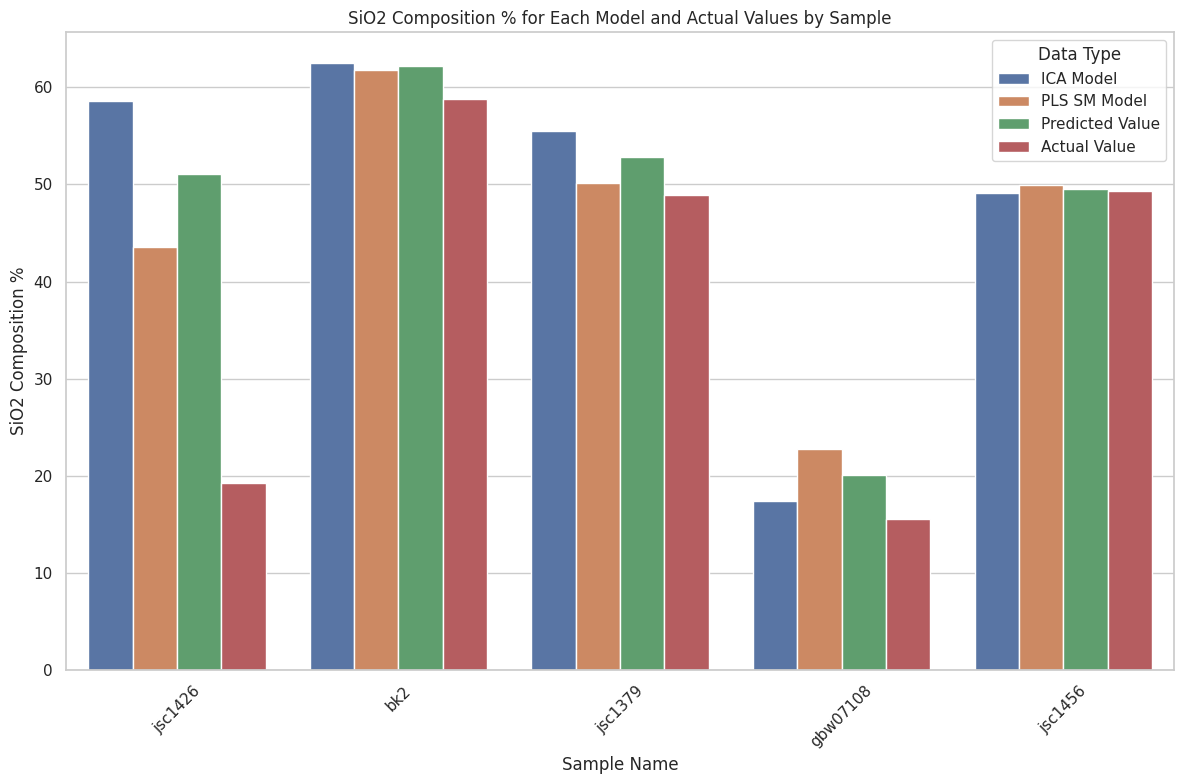

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Setting the style for the plot
sns.set(style="whitegrid")

# Creating a figure for the plot
plt.figure(figsize=(12, 8))

# Creating aliases for the value_vars
aliases = {
    'SiO2_ICA': 'ICA Model',
    'SiO2_PLS_SM': 'PLS SM Model',
    'SiO2_pred': 'Predicted Value',
    'SiO2_actual': 'Actual Value'
}

# Merging the data for actual and predicted values for the plot
melted_data = pd.melt(SiO2_eval_df, id_vars='Sample Name', value_vars=list(aliases.keys()))

# Renaming the columns based on aliases
melted_data = melted_data.rename(columns={'variable': 'Model/Value', 'value': 'SiO2 Composition %'})
melted_data['Model/Value'] = melted_data['Model/Value'].map(aliases)

# Creating the grouped bar chart
sns.barplot(x='Sample Name', y='SiO2 Composition %', hue='Model/Value', data=melted_data)

# Adding labels and title
plt.xlabel('Sample Name')
plt.ylabel('SiO2 Composition %')
plt.title('SiO2 Composition % for Each Model and Actual Values by Sample')
plt.xticks(rotation=45)
plt.legend(title='Data Type')

plt.gca().invert_yaxis()

# Displaying the plot
plt.tight_layout()
plt.show()

In [16]:
merged_moc_actual_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
0,51.079468,19.3,-0.081466,0.08,3.035842,1.49,37.714411,65.85,0.144481,0.77,2.443497,0.77,3.033228,0.45,0.825492,0.16,jsc1426
1,62.181605,58.83,0.807386,1.94,15.636510,14.77,5.233321,7.90,2.707093,2.82,4.298205,4.64,2.134479,3.35,3.553706,3.99,bk2
2,52.847836,48.93,0.724178,0.57,17.959557,22.66,9.007637,7.67,4.843410,4.34,7.963560,9.80,3.550036,3.13,1.574669,0.45,jsc1379
3,20.035683,15.6,0.224314,0.33,6.695827,5.03,3.709306,2.27,6.393537,5.19,30.954491,35.67,1.259410,0.08,0.210390,0.78,gbw07108
4,49.515835,49.31,2.081282,2.72,16.744077,16.46,10.658171,10.93,5.035905,3.93,6.593610,6.75,3.919862,4.58,1.254012,1.82,jsc1456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,42.529275,44.64,2.129275,2.37,15.660422,13.83,11.866672,12.06,8.446982,7.77,7.894668,8.81,3.565167,3.38,0.457240,2.32,gbw07105
67,52.537714,33.81,0.085228,0.82,10.096603,11.87,13.188952,16.52,-3.457429,0.92,5.464687,0.86,4.157699,0.07,1.906428,0.33,sarm51
68,63.888105,67.4,0.763167,0.9,17.132019,16.30,6.348280,5.14,3.371712,1.81,0.254734,0.21,-0.436849,0.81,3.699009,3.4,s4
69,76.546918,77.54,0.186787,0.33,12.782315,11.17,2.975451,2.54,1.066541,1.08,-0.073748,0.07,1.927240,2.33,3.468249,2.39,gl7mt


In [17]:
moc_rmse_values

{'SiO2': 7.400753900531163,
 'TiO2': 0.4756772560247421,
 'Al2O3': 2.2368489085844576,
 'FeOT': 4.933289074424042,
 'MgO': 1.6845887626237948,
 'CaO': 1.8730929950102295,
 'Na2O': 1.0248375496677138,
 'K2O': 1.147689218317043}

In [18]:
ICA_actual_merged_df = merge_with_actual_data(aligned_pred_ICA)
ICA_rmses = calculate_rmse(ICA_actual_merged_df)

PLS_SM_actual_merged_df = merge_with_actual_data(aligned_pred_PLS_SM)
PLS_SM_rmses = calculate_rmse(PLS_SM_actual_merged_df)

ICA_rmses

/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/christian/projects/p9/baseline/venv/lib/python3.10/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squa

{'SiO2': 10.785246665768561,
 'TiO2': 0.5760836075817665,
 'Al2O3': 4.918967500078084,
 'FeOT': 8.27375987254099,
 'MgO': 2.899462878109565,
 'CaO': 3.4877489584638934,
 'Na2O': 1.648846094289413,
 'K2O': 1.4273925629930975}

In [19]:
PLS_SM_actual_merged_df

,SiO2_pred,SiO2_actual,TiO2_pred,TiO2_actual,Al2O3_pred,Al2O3_actual,FeOT_pred,FeOT_actual,MgO_pred,MgO_actual,CaO_pred,CaO_actual,Na2O_pred,Na2O_actual,K2O_pred,K2O_actual,Sample Name
jsc1426_2013_09_16_151528_ccs,43.583565,19.3,0.117548,0.08,2.121363,1.49,45.031716,65.85,0.527079,0.77,0.839088,0.77,0.503439,0.45,0.194280,0.16,jsc1426
bk2_2013_08_06_184259_ccs,61.820335,58.83,0.797119,1.94,15.720130,14.77,5.127755,7.90,2.073301,2.82,4.577359,4.64,3.980115,3.35,3.591427,3.99,bk2
jsc1379_2013_09_10_142041_ccs,50.178211,48.93,0.670133,0.57,18.985118,22.66,8.604136,7.67,4.305420,4.34,9.084772,9.80,3.749899,3.13,0.668436,0.45,jsc1379
gbw07108_2013_08_07_145651_ccs,22.709394,15.6,0.305295,0.33,7.090361,5.03,2.815069,2.27,2.910417,5.19,33.555799,35.67,0.662775,0.08,0.629373,0.78,gbw07108
jsc1456_2013_09_18_160559_ccs,49.955437,49.31,2.535613,2.72,16.470758,16.46,10.564013,10.93,4.419676,3.93,8.073967,6.75,4.505630,4.58,1.470754,1.82,jsc1456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gbw07105_2013_08_07_142727_ccs,44.773871,44.64,2.218118,2.37,14.434764,13.83,11.281119,12.06,7.499811,7.77,8.402023,8.81,3.721762,3.38,1.410732,2.32,gbw07105
sarm51_2013_08_29_145612_ccs,48.201845,33.81,0.429323,0.82,9.515069,11.87,14.095175,16.52,0.850564,0.92,2.163324,0.86,0.478211,0.07,0.631313,0.33,sarm51
s4_2013_11_05_155948_ccs,64.137117,67.4,0.838158,0.9,18.963085,16.30,5.654088,5.14,2.257779,1.81,0.484870,0.21,0.683235,0.81,3.813765,3.4,s4
gl7mt_2013_10_23_144551_ccs,78.087196,77.54,0.321695,0.33,11.934541,11.17,3.275283,2.54,1.717576,1.08,-0.382714,0.07,2.283547,2.33,2.182839,2.39,gl7mt


In [20]:
PLS_SM_rmses

{'SiO2': 6.337002982990323,
 'TiO2': 0.48213773647537583,
 'Al2O3': 1.9502148907628378,
 'FeOT': 3.9975356327218736,
 'MgO': 1.2091519636234427,
 'CaO': 1.4896419466393878,
 'Na2O': 0.6649369478235515,
 'K2O': 0.7106532470431329}

In [21]:
RMSEs_df = pd.DataFrame([ICA_rmses, PLS_SM_rmses, moc_rmse_values], index=["ICA", "PLS_SM", "MOC"])

In [22]:
RMSEs_df.T

,ICA,PLS_SM,MOC
SiO2,10.785247,6.337003,7.400754
TiO2,0.576084,0.482138,0.475677
Al2O3,4.918968,1.950215,2.236849
FeOT,8.273760,3.997536,4.933289
MgO,2.899463,1.209152,1.684589
CaO,3.487749,1.489642,1.873093
Na2O,1.648846,0.664937,1.024838
K2O,1.427393,0.710653,1.147689
